<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/Notebooks/UEBB_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads

In [1]:
!pip install catboost

In [2]:
!pip install optuna

In [5]:
import os
directory_path = "datasets/Brazil"
url = "https://zenodo.org/record/1475197/files/UEBB_v1.nc?download=1"
file_name = "UEBB_v1.nc"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Use wget to download the file
!wget -O "{os.path.join(directory_path, file_name)}" "{url}"

--2023-09-03 10:36:30--  https://zenodo.org/record/1475197/files/UEBB_v1.nc?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162776597 (155M) [application/octet-stream]
Saving to: ‘datasets/Brazil/UEBB_v1.nc’

datasets/Brazil/UEB 100%[===================>] 155.24M  6.43MB/s    in 51s     

2023-09-03 10:37:23 (3.07 MB/s) - ‘datasets/Brazil/UEBB_v1.nc’ saved [162776597/162776597]



# Imports

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline

from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [3]:
! git clone https://github.com/atahanoezer/Wind.git

fatal: destination path 'Wind' already exists and is not an empty directory.


In [4]:
from Wind.dataset import Dataset
from Wind.utils import experiment_results
from Wind.model import *

In [5]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [6]:
uebb = 'datasets/Brazil/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df =df.loc[(df.index.get_level_values('Turbine') == 1.0) & (df.index.get_level_values('Height') == 60.0)]
df = df.reset_index()
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [7]:
test_time = pd.to_datetime('2014-05-18 18:50:00')
df_test = df[df.index >= test_time]
test_split = len(df_test)/len(df)

Following fields are observed via pandas profiling, reports can be generated by running the profiler function in utils.py

In [8]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected'] #
missing_fields = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

In [9]:
roll_window = 4
dataset = Dataset(df)
dataset.fill_nan(missing_fields)
dataset.drop_nan(high_empty_fields)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
dataset.apply_rolling_window(dataset.df,'wind_speed', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'air_pressure', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'rotor_rpm', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'wind_speed_nacelle', roll_window,np.mean)

# One-Shot Modelling



## Next Step Prediction



In [10]:
window = 48
horizon =1
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate = False
                                                                     ,val_split = 0.1)

### Default

In [11]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.2191126	test: 241.4391529	best: 241.4391529 (0)	total: 12.1ms	remaining: 12.1s


500:	learn: 44.7534817	test: 35.9710254	best: 35.9323563 (478)	total: 4.95s	remaining: 4.93s
999:	learn: 42.6539719	test: 36.1520892	best: 35.9323563 (478)	total: 9.64s	remaining: 0us
bestTest = 35.93235628
bestIteration = 478
Shrink model to first 479 iterations.


                  MAE       RMSE        R2
Validation  21.332994  35.932356  0.919593
Test        34.104791  52.417465  0.937889


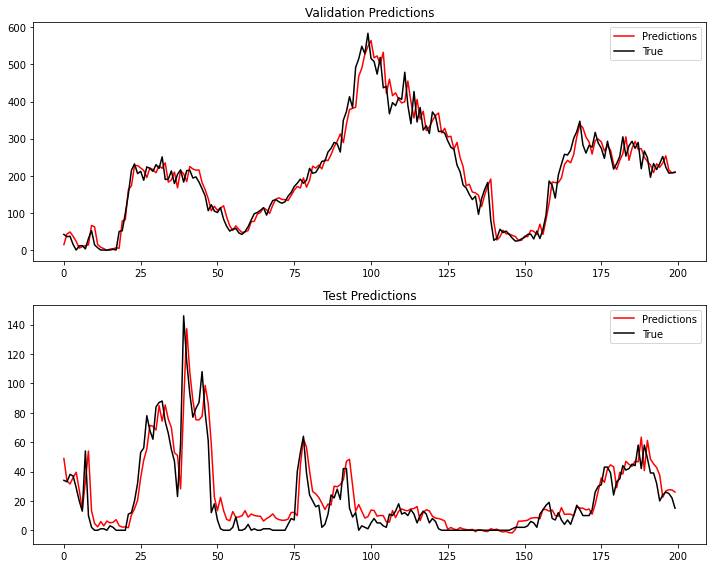

In [12]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Feat Select

In [13]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats = 52,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [14]:
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.3628376	test: 241.1743844	best: 241.1743844 (0)	total: 9.66ms	remaining: 9.65s
500:	learn: 45.0510911	test: 35.6206749	best: 35.6206749 (500)	total: 4.25s	remaining: 4.24s
999:	learn: 43.0645097	test: 35.3930582	best: 35.3897816 (991)	total: 8.5s	remaining: 0us
bestTest = 35.38978163
bestIteration = 991
Shrink model to first 992 iterations.


                  MAE       RMSE        R2
Validation  21.231992  35.389780  0.922003
Test        34.163666  52.723029  0.937162


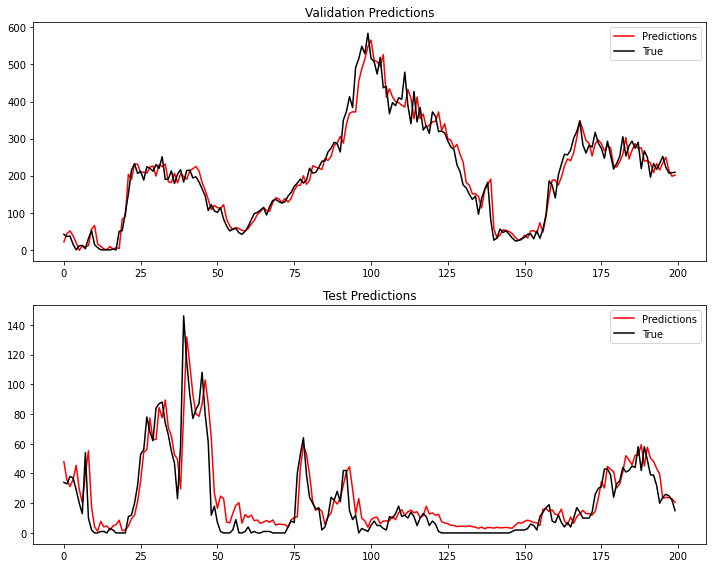

In [15]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op

In [16]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-09-04 20:28:16,141] A new study created in memory with name: no-name-9fda1fc3-742d-4ed0-be4c-408d1c191324
[I 2023-09-04 20:28:21,755] Trial 0 finished with value: 21.381857117846227 and parameters: {'learning_rate': 0.036220139288789525, 'depth': 4, 'min_data_in_leaf': 83}. Best is trial 0 with value: 21.381857117846227.
[I 2023-09-04 20:28:51,339] Trial 1 finished with value: 21.42109941066416 and parameters: {'learning_rate': 0.008471956566295414, 'depth': 9, 'min_data_in_leaf': 24}. Best is trial 0 with value: 21.381857117846227.
[I 2023-09-04 20:28:57,315] Trial 2 finished with value: 21.910644659716006 and parameters: {'learning_rate': 0.008440881482080855, 'depth': 4, 'min_data_in_leaf': 63}. Best is trial 0 with value: 21.381857117846227.
[I 2023-09-04 20:29:04,651] Trial 3 finished with value: 21.62502009989095 and parameters: {'learning_rate': 0.010162790971182362, 'depth': 5, 'min_data_in_leaf': 34}. Best is trial 0 with value: 21.381857117846227.
[I 2023-09-04 20:29:

Best hyperparameters: {'learning_rate': 0.033389178324436185, 'depth': 10, 'min_data_in_leaf': 51}
Best RMSE: 20.924323773771423


({'learning_rate': 0.033389178324436185, 'depth': 10, 'min_data_in_leaf': 51},
 20.924323773771423)

                  MAE       RMSE        R2
Validation  21.059340  35.782216  0.920264
Test        33.428009  51.545493  0.939938


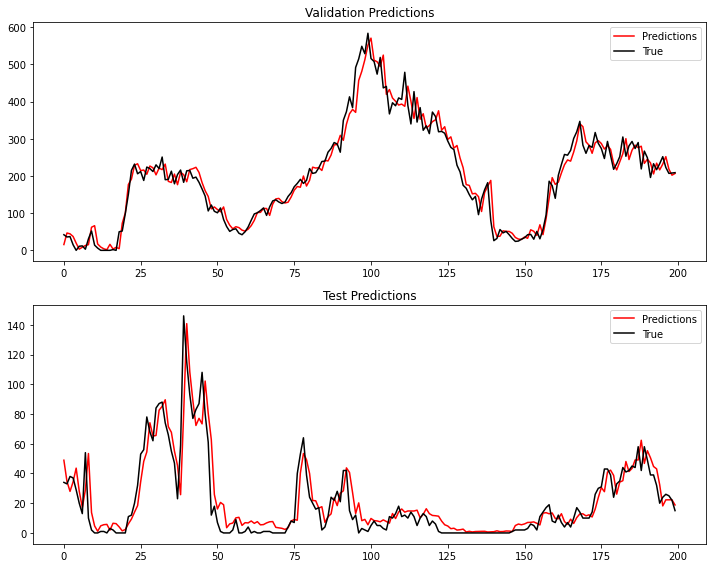

In [17]:
next_step_os_feat_hy,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op Transfer

In [18]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64})
model.train(train_x, train_y, val_x, val_y)

0:	learn: 218.7665357	test: 248.9598208	best: 248.9598208 (0)	total: 34ms	remaining: 34s
500:	learn: 44.7203885	test: 35.8045095	best: 35.8045095 (500)	total: 13.2s	remaining: 13.1s
999:	learn: 41.9918724	test: 35.6618134	best: 35.6280423 (848)	total: 28s	remaining: 0us
bestTest = 35.62804234
bestIteration = 848
Shrink model to first 849 iterations.


                  MAE       RMSE        R2
Validation  21.080885  35.628041  0.920949
Test        33.632782  51.959813  0.938969


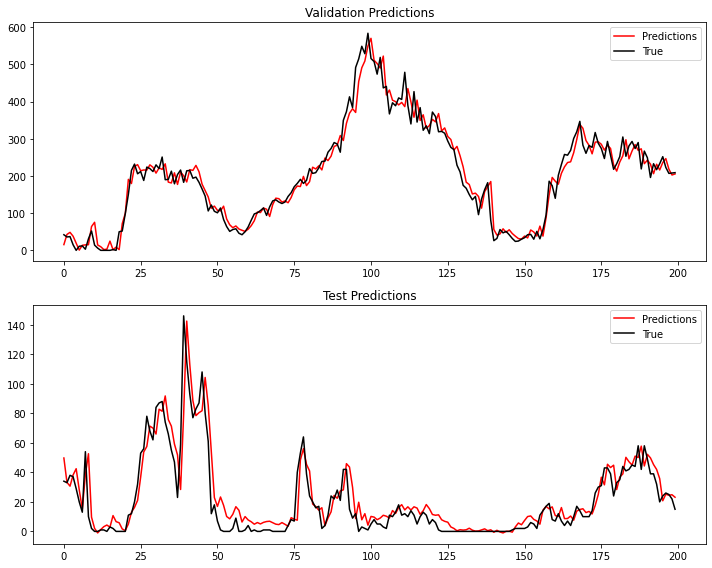

In [19]:
next_step_os_transfer,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



## Next Hour Prediction



### Default

In [20]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y, columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,val_split = 0.1)

In [21]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091606
0:	learn: 216.3626917	test: 244.1634301	best: 244.1634301 (0)	total: 11.6ms	remaining: 11.6s


500:	learn: 84.3092826	test: 70.7783965	best: 70.6920385 (445)	total: 5.08s	remaining: 5.06s
999:	learn: 77.5455105	test: 71.4833875	best: 70.6920385 (445)	total: 10.1s	remaining: 0us
bestTest = 70.69203853
bestIteration = 445
Shrink model to first 446 iterations.


                  MAE        RMSE        R2
Validation  48.274549   70.692043  0.688824
Test        77.657147  110.062458  0.726131


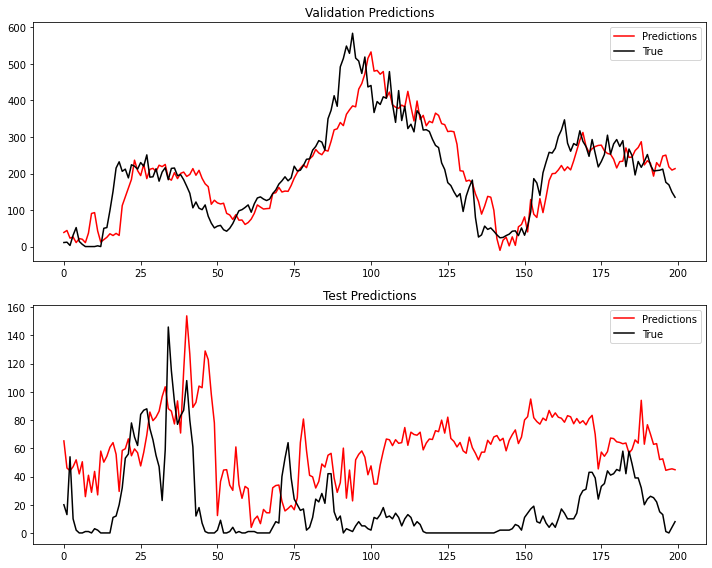

In [22]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [23]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =52,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


In [24]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1])

Learning rate set to 0.091606
0:	learn: 216.2912379	test: 244.1328160	best: 244.1328160 (0)	total: 9.85ms	remaining: 9.84s
500:	learn: 85.1550501	test: 70.3371292	best: 70.0555076 (213)	total: 4.43s	remaining: 4.42s
999:	learn: 79.0800403	test: 70.9623272	best: 70.0555076 (213)	total: 8.92s	remaining: 0us
bestTest = 70.05550755
bestIteration = 213
Shrink model to first 214 iterations.


                  MAE        RMSE        R2
Validation  47.261715   70.055506  0.694403
Test        76.401266  107.943006  0.736577


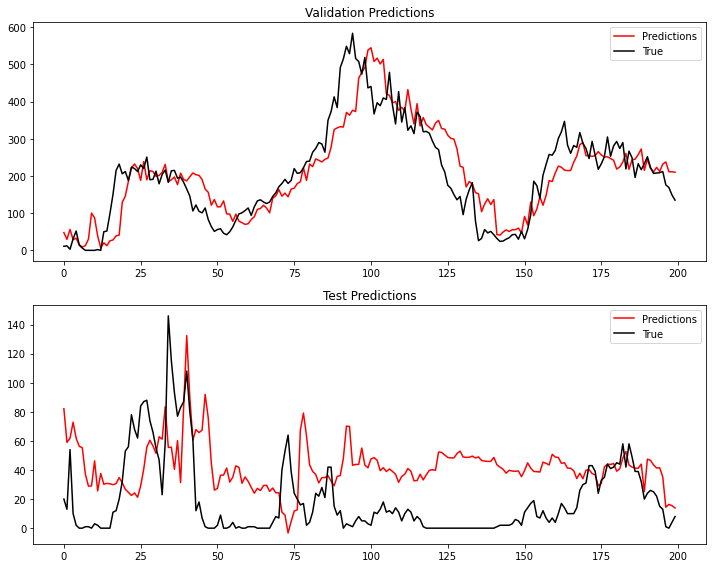

In [25]:
next_hour_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [26]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-04 20:39:21,411] A new study created in memory with name: no-name-51a9a5cd-bfbf-46f5-98bc-1c52fe863e02
[I 2023-09-04 20:39:28,501] Trial 0 finished with value: 48.89958123329738 and parameters: {'learning_rate': 0.007130620763494733, 'depth': 5, 'min_data_in_leaf': 36}. Best is trial 0 with value: 48.89958123329738.
[I 2023-09-04 20:39:47,926] Trial 1 finished with value: 46.84453171491601 and parameters: {'learning_rate': 0.021166313014059437, 'depth': 8, 'min_data_in_leaf': 20}. Best is trial 1 with value: 46.84453171491601.
[I 2023-09-04 20:39:51,969] Trial 2 finished with value: 87.43084200443013 and parameters: {'learning_rate': 0.003091517531654384, 'depth': 1, 'min_data_in_leaf': 62}. Best is trial 1 with value: 46.84453171491601.
[I 2023-09-04 20:40:11,578] Trial 3 finished with value: 46.81313112262091 and parameters: {'learning_rate': 0.048410504637025537, 'depth': 8, 'min_data_in_leaf': 28}. Best is trial 3 with value: 46.81313112262091.
[I 2023-09-04 20:40:16,951

Best hyperparameters: {'learning_rate': 0.059724608902207627, 'depth': 7, 'min_data_in_leaf': 34}
Best RMSE: 46.36614707810584


({'learning_rate': 0.059724608902207627, 'depth': 7, 'min_data_in_leaf': 34},
 46.36614707810584)

                  MAE        RMSE        R2
Validation  49.053901   72.360348  0.673963
Test        76.886176  107.768929  0.737426


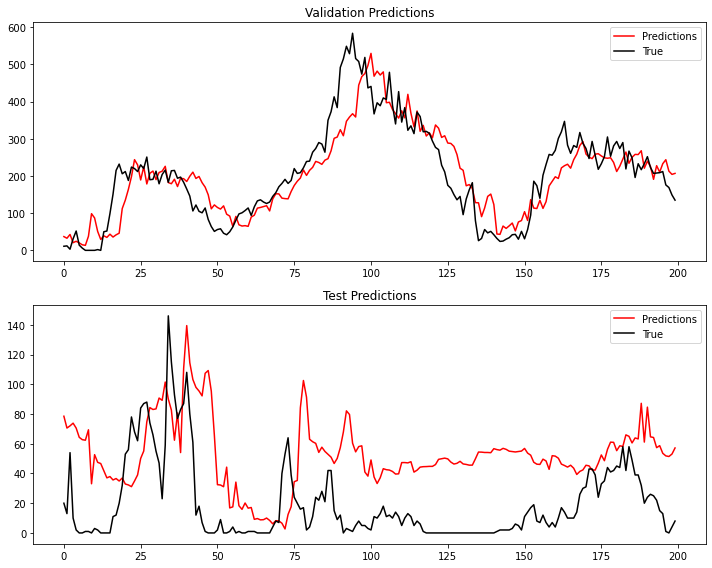

In [27]:
next_hour_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [28]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.01295853204616923, 'depth': 6, 'min_data_in_leaf': 70})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.2199011	test: 261.0504599	best: 261.0504599 (0)	total: 9.06ms	remaining: 9.05s


500:	learn: 98.2222419	test: 71.9877076	best: 71.9877076 (500)	total: 4.59s	remaining: 4.57s
999:	learn: 94.4535073	test: 70.7590777	best: 70.7496949 (985)	total: 9.13s	remaining: 0us
bestTest = 70.74969491
bestIteration = 985
Shrink model to first 986 iterations.


                  MAE        RMSE        R2
Validation  47.293116   70.749692  0.688316
Test        75.558567  106.965344  0.741327


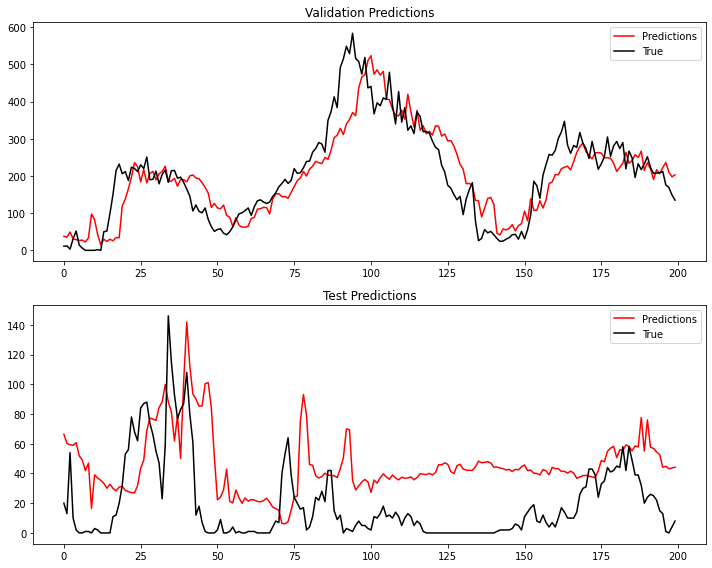

In [29]:
next_hour_os_transfer,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

## Next Day Prediction

In [30]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,val_split=0.1)

### Default

In [31]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 221.8305069	test: 253.8753265	best: 253.8753265 (0)	total: 14.8ms	remaining: 14.7s


500:	learn: 105.2021357	test: 121.7485297	best: 121.1725554 (493)	total: 6.43s	remaining: 6.41s
999:	learn: 87.4341087	test: 120.1974320	best: 118.2237467 (826)	total: 12.6s	remaining: 0us
bestTest = 118.2237467
bestIteration = 826
Shrink model to first 827 iterations.


                   MAE        RMSE        R2
Validation   90.186445  118.223766  0.116899
Test        149.102038  186.474719  0.209482


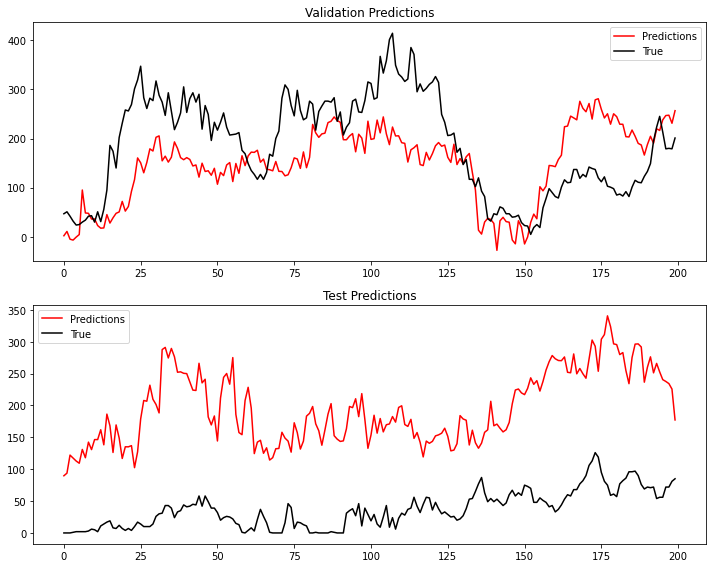

In [32]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [33]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =52,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [34]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 222.0683731	test: 255.0198329	best: 255.0198329 (0)	total: 9.39ms	remaining: 9.38s
500:	learn: 112.6480016	test: 116.0570009	best: 115.9837050 (494)	total: 4.54s	remaining: 4.53s
999:	learn: 98.3952762	test: 118.5001054	best: 115.8191297 (507)	total: 8.7s	remaining: 0us
bestTest = 115.8191297
bestIteration = 507
Shrink model to first 508 iterations.


                   MAE        RMSE        R2
Validation   85.809304  115.819131  0.152458
Test        156.049101  191.793332  0.163745


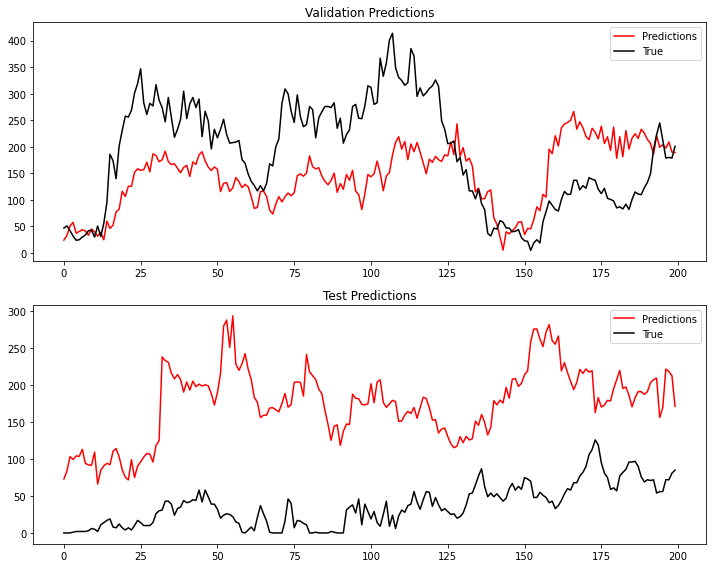

In [35]:
next_day_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [36]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-04 20:48:13,834] A new study created in memory with name: no-name-5c8edea5-01d0-49f9-9afe-9391608a162e
[I 2023-09-04 20:48:33,537] Trial 0 finished with value: 87.99656365611847 and parameters: {'learning_rate': 0.05368273698652575, 'depth': 8, 'min_data_in_leaf': 74}. Best is trial 0 with value: 87.99656365611847.
[I 2023-09-04 20:49:33,535] Trial 1 finished with value: 125.2122312209468 and parameters: {'learning_rate': 0.004720787820441077, 'depth': 10, 'min_data_in_leaf': 55}. Best is trial 0 with value: 87.99656365611847.
[I 2023-09-04 20:49:40,885] Trial 2 finished with value: 110.28742531162817 and parameters: {'learning_rate': 0.003446268208042766, 'depth': 5, 'min_data_in_leaf': 6}. Best is trial 0 with value: 87.99656365611847.
[I 2023-09-04 20:49:46,990] Trial 3 finished with value: 100.14409056965245 and parameters: {'learning_rate': 0.011529795270266442, 'depth': 4, 'min_data_in_leaf': 70}. Best is trial 0 with value: 87.99656365611847.
[I 2023-09-04 20:49:51,49

Best hyperparameters: {'learning_rate': 0.04885499037791739, 'depth': 5, 'min_data_in_leaf': 22}
Best RMSE: 78.67520330968304


({'learning_rate': 0.04885499037791739, 'depth': 5, 'min_data_in_leaf': 22},
 78.67520330968304)

                   MAE        RMSE        R2
Validation   88.296021  115.577501  0.155991
Test        153.749975  189.205264  0.186161


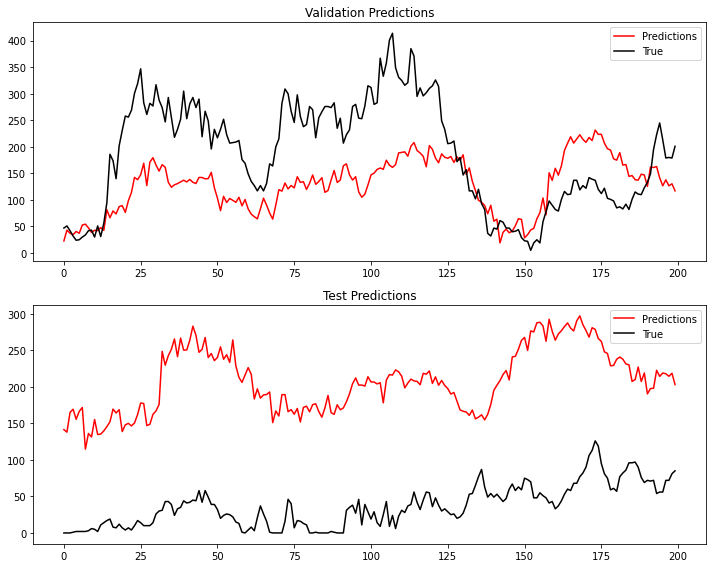

In [37]:
next_day_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [38]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.0289836229349701, 'depth': 2, 'min_data_in_leaf': 62})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.1412737	test: 262.7558710	best: 262.7558710 (0)	total: 4.71ms	remaining: 4.7s
500:	learn: 160.6626520	test: 126.6403499	best: 126.5868106 (492)	total: 2s	remaining: 1.99s
999:	learn: 156.5691228	test: 125.6305855	best: 125.6305855 (999)	total: 3.99s	remaining: 0us
bestTest = 125.6305855
bestIteration = 999


                   MAE        RMSE        R2
Validation  101.334943  125.630641  0.002778
Test        153.959757  188.240838  0.194437


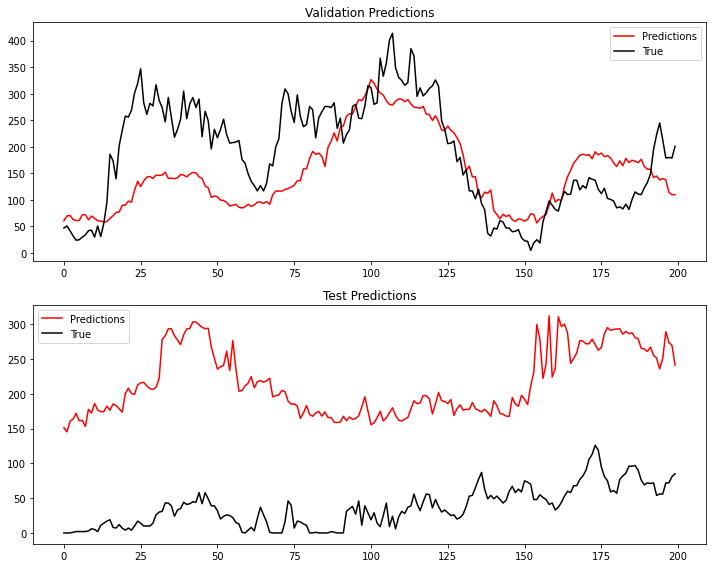

In [39]:
next_day_os_transfer,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

# Recursive Modelling

## Next Hour

In [40]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate= True,val_split=0.1)

### Default Recursive

In [41]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.091606
0:	learn: 212.4690347	test: 241.0548013	best: 241.0548013 (0)	total: 10ms	remaining: 9.99s


500:	learn: 53.9880683	test: 39.5907964	best: 39.5526824 (477)	total: 4.09s	remaining: 4.08s
999:	learn: 51.9025178	test: 39.6462252	best: 39.5526824 (477)	total: 8.13s	remaining: 0us
bestTest = 39.55268237
bestIteration = 477
Shrink model to first 478 iterations.


                  MAE       RMSE        R2
Validation  29.973624  45.626716  0.870392
Test        49.411526  71.510847  0.884390


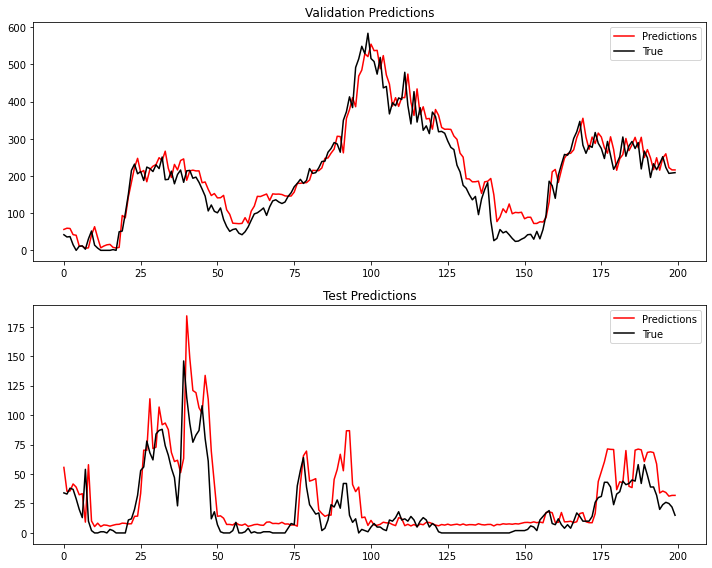

In [42]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

### Recursive with Transferred Hyp-op

In [43]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

0:	learn: 218.6752048	test: 248.8400759	best: 248.8400759 (0)	total: 32.1ms	remaining: 32.1s


500:	learn: 53.0566963	test: 39.5246717	best: 39.5155461 (490)	total: 13.7s	remaining: 13.6s
999:	learn: 50.6247113	test: 39.5368323	best: 39.5028764 (539)	total: 26.1s	remaining: 0us
bestTest = 39.50287638
bestIteration = 539
Shrink model to first 540 iterations.


                  MAE       RMSE        R2
Validation  30.906827  46.311693  0.866471
Test        50.600276  72.057299  0.882617


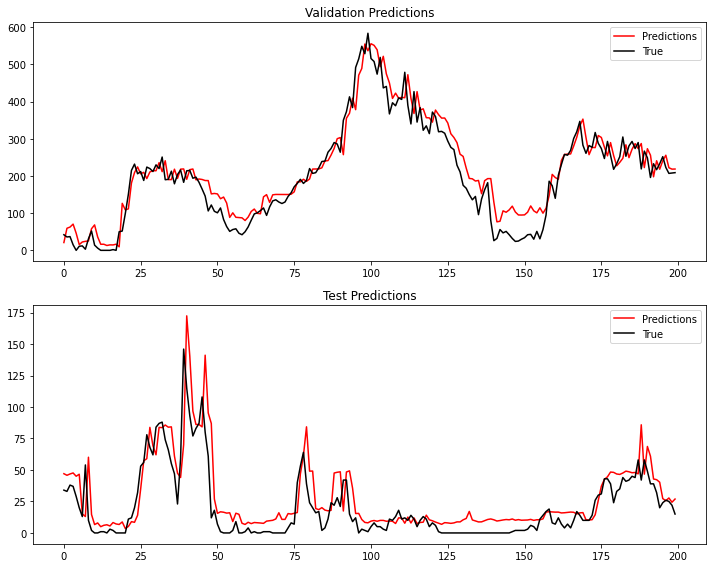

In [44]:
next_hour_rec_transfer,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

## Next Day

## Default Recursive

In [45]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,univariate=True,val_split=0.1)

In [46]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.091542
0:	learn: 212.3232847	test: 240.5060965	best: 240.5060965 (0)	total: 12.7ms	remaining: 12.7s


500:	learn: 53.1140213	test: 40.1492765	best: 39.9146214 (181)	total: 5.47s	remaining: 5.45s
999:	learn: 50.4144344	test: 40.5031334	best: 39.9146214 (181)	total: 10.7s	remaining: 0us
bestTest = 39.91462138
bestIteration = 181
Shrink model to first 182 iterations.


                   MAE        RMSE        R2
Validation   48.210901   72.874689  0.672441
Test        107.728681  142.285493  0.543361


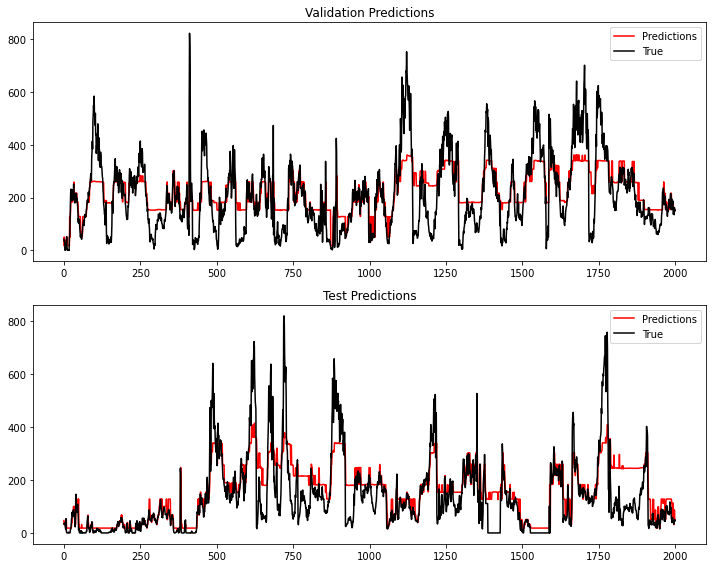

In [47]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

### Recursive with Transferred Hyp-op

In [48]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

0:	learn: 218.6578503	test: 247.6320621	best: 247.6320621 (0)	total: 52.8ms	remaining: 52.7s
500:	learn: 51.6893258	test: 39.7549899	best: 39.7170242 (381)	total: 21.1s	remaining: 21.1s
999:	learn: 48.7038744	test: 39.9299724	best: 39.7170242 (381)	total: 41.4s	remaining: 0us
bestTest = 39.71702419
bestIteration = 381
Shrink model to first 382 iterations.


                   MAE        RMSE        R2
Validation   45.918971   71.821149  0.681843
Test        102.999417  136.212515  0.581509


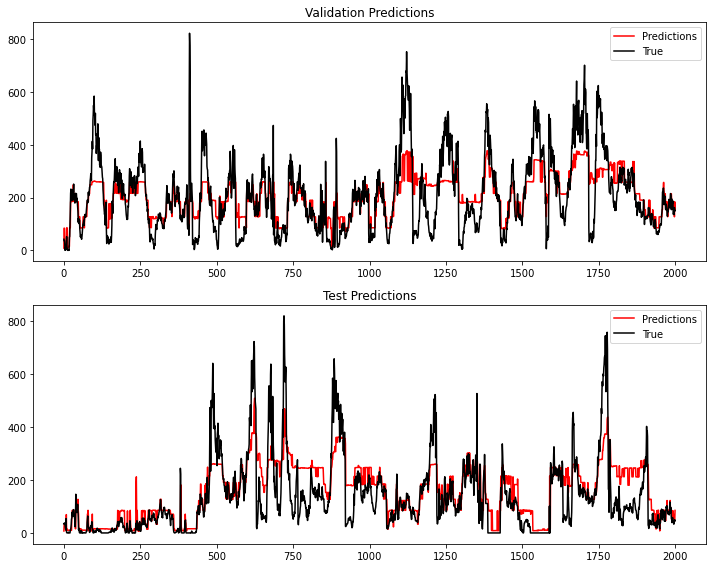

In [49]:
next_day_rec_transfer,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [54]:
next_step_baseline = {'MAE': 91.554 , 'RMSE': 145.603, 'R2':0 }
results = [next_step_baseline,next_step_os.iloc[1,:],next_step_os_feat.iloc[1,:],next_step_os_feat_hy.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', 'One Shot Feat + Hyp-op']

experiment_results(names, results,title = 'Next Step Prediction')

| Metric                 | MAE        | RMSE       | R2       |
|:-----------------------|:-----------|:-----------|:---------|
| Next Step Prediction   |            |            |          |
| Baseline               | 91.554     | 145.603    | -        |
| One Shot               | 34.105     | 52.417     | 0.938    |
| One Shot Feat          | 34.164     | 52.723     | 0.937    |
| One Shot Feat + Hyp-op | **33.428** | **51.545** | **0.94** |


In [55]:
next_hour_baseline = {'MAE': 183.286 , 'RMSE': 263.749	, 'R2':0 }
results = [next_hour_baseline,next_hour_os.iloc[1,:],next_hour_os_feat.iloc[1,:],next_hour_os_feat_hy.iloc[1,:],next_hour_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Hour Prediction')

| Metric                 | MAE        | RMSE       | R2        |
|:-----------------------|:-----------|:-----------|:----------|
| Next Hour Prediction   |            |            |           |
| Baseline               | 183.286    | 263.749    | -         |
| One Shot               | 77.657     | 110.062    | 0.726     |
| One Shot Feat          | 76.401     | 107.943    | 0.737     |
| One Shot Feat + Hyp-op | 76.886     | 107.769    | 0.737     |
| Recursive              | **49.412** | **71.511** | **0.884** |


In [52]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }
results = [next_day_baseline,next_day_os.iloc[1,:],next_day_os_feat.iloc[1,:],next_day_os_feat_hy.iloc[1,:], next_day_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Day Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Day Prediction    |             |             |           |
| Baseline               | 510.71      | 623.023     | -         |
| One Shot               | 149.102     | 186.475     | 0.209     |
| One Shot Feat          | 156.049     | 191.793     | 0.164     |
| One Shot Feat + Hyp-op | 153.75      | 189.205     | 0.186     |
| Recursive              | **107.729** | **142.285** | **0.543** |


In [56]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }
results = [ next_step_os_feat_hy.iloc[1,:],next_step_os_transfer.iloc[1,:],
            next_hour_os_feat_hy.iloc[1,:],next_hour_os_transfer.iloc[1,:],
            next_hour_rec.iloc[1,:],next_hour_rec_transfer.iloc[1,:]
            ,next_day_os_feat_hy.iloc[1,:],next_day_os_transfer.iloc[1,:]
           , next_day_rec.iloc[1,:],next_day_rec_transfer.iloc[1,:]]

names = ['Next step Hyp-op','Next step Transfer Hyp-op',
         'Next hour Hyp-op','Next hour Transfer Hyp-op',
         'Next hour Recursive', 'Next hour Recursive Transfer Hyp-op',
         'Next day Hyp-op','Next day Transfer Hyp-op',
         'Next day Recursive', 'Next day Recursive Transfer Hyp-op']

experiment_results(names, results,title = 'Transfer Prediction')

| Metric                              | MAE        | RMSE       | R2       |
|:------------------------------------|:-----------|:-----------|:---------|
| Transfer Prediction                 |            |            |          |
| Next step Hyp-op                    | **33.428** | **51.545** | **0.94** |
| Next step Transfer Hyp-op           | 33.633     | 51.96      | 0.939    |
| Next hour Hyp-op                    | 76.886     | 107.769    | 0.737    |
| Next hour Transfer Hyp-op           | 75.559     | 106.965    | 0.741    |
| Next hour Recursive                 | 49.412     | 71.511     | 0.884    |
| Next hour Recursive Transfer Hyp-op | 50.6       | 72.057     | 0.883    |
| Next day Hyp-op                     | 153.75     | 189.205    | 0.186    |
| Next day Transfer Hyp-op            | 153.96     | 188.241    | 0.194    |
| Next day Recursive                  | 107.729    | 142.285    | 0.543    |
| Next day Recursive Transfer Hyp-op  | 102.999    | 136.213    | 0.582    |